In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
#I open the Era5 files with 1h data
path = "/groups/EXTREMES/cutouts/"
files = [f'{path}europe-{year}-era5.nc' for year in range(2001, 2002)]
field="influx_direct"

# Open multiple ERA5 datasets
df = xr.open_mfdataset(files, combine="by_coords", join="inner")

In [10]:
df

<xarray.Dataset> Size: 17GB
Dimensions:           (x: 189, y: 157, time: 8760)
Coordinates:
  * x                 (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
  * y                 (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
  * time              (time) datetime64[ns] 70kB 2001-01-01 ... 2001-12-31T23...
    lon               (x) float64 2kB dask.array<chunksize=(189,), meta=np.ndarray>
    lat               (y) float64 1kB dask.array<chunksize=(157,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 119kB dask.array<chunksize=(157, 189), meta=np.ndarray>
    wnd100m           (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    roughness         (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    influx_toa        (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    influx_direct     (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 2GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 2GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    temperature       (time, y, x) float64 2GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    soil temperature  (time, y, x) float64 2GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
    runoff            (time, y, x) float32 1GB dask.array<chunksize=(8760, 157, 189), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'height', 'temperature', 'wind', 'influx']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-02-14 14:51:22 GMT by grib_to_netcdf-2.25.1: /op...

In [4]:
# now I am taking the mean over the time dimension without doing any change
df[field].mean(dim="time").size

29673

In [5]:
# Ensure time is sorted
df = df.sortby("time")

In [50]:
  # Resample and sum over each 3-hour period.
# Convert irradiance to energy, sum over 3-hour periods, and calculate average irradiance
# Resample and calculate average irradiance over 3-hour periods
irradiance_3h_accumulated = (
    df[field]  # Access the field
    .resample(time="3H", label="left", closed="right")  # Resample to 3-hour periods
    .map(lambda x: (x * 3600).sum(dim="time") / (3 * 3600))  # Convert to energy, sum, and average back to irradiance
)


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


In [56]:
import pandas as pd
irradiance_3h_accumulated["time"] = irradiance_3h_accumulated["time"] + pd.Timedelta(hours=1.5)
irradiance_3h_accumulated

<xarray.DataArray 'influx_direct' (time: 2921, y: 157, x: 189)> Size: 347MB
dask.array<concatenate, shape=(2921, 157, 189), dtype=float32, chunksize=(1, 157, 189), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2kB -12.0 -11.75 -11.5 -11.25 ... 34.25 34.5 34.75 35.0
  * y        (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.25 71.5 71.75 72.0
    lon      (x) float64 2kB dask.array<chunksize=(189,), meta=np.ndarray>
    lat      (y) float64 1kB dask.array<chunksize=(157,), meta=np.ndarray>
  * time     (time) datetime64[ns] 23kB 2001-01-01T01:30:00 ... 2002-01-01T01...

In [57]:
#mean for each grid cell of the 3h accumulated data
irradiance_3h_accumulated.mean(dim="time").sel(x=2, y=42, method="nearest").values

array(129.84883, dtype=float32)

In [58]:
#mean for each grid cell of the original 1h data
df['influx_direct'].mean(dim='time').sel(x=2, y=42, method="nearest").values

array(129.89316, dtype=float32)

In [4]:
fn="/groups/FutureWind/SFCRAD/MRI-ESM2-0/historical/r1i1p1f1/rsds_rsdsdiff_tas_2001.nc"
ds = xr.open_dataset(fn)
ds['rsds'].mean(dim='time').sel(lon=2, lat=42, method="nearest").values

array(195.14822, dtype=float32)

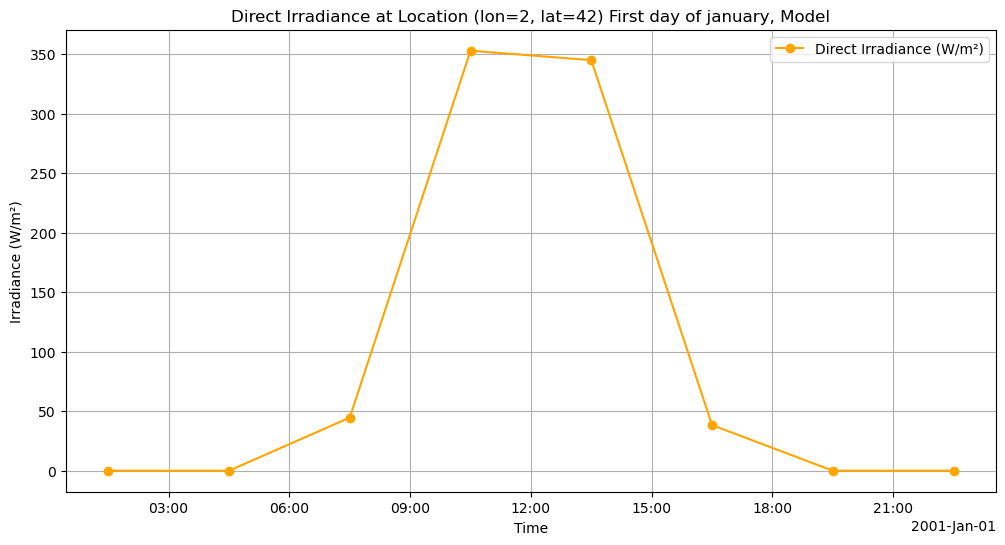

In [17]:
# Select the irradiance values for the specified location
direct_irradiance_model = ds['rsds'].sel(lon=2, lat=42, method="nearest")

# Plot the irradiance values over time
plt.figure(figsize=(12, 6))
direct_irradiance_model[:8].plot(label="Direct Irradiance (W/m²)", color="orange",marker="o")
plt.title("Direct Irradiance at Location (lon=2, lat=42) First day of january, Model")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()

In [20]:
direct_irradiance_model_sum = ds['rsds'].sel(lon=2, lat=42, method="nearest").sum(dim="time")
print(direct_irradiance_model_sum/1000)

<xarray.DataArray 'rsds' ()> Size: 4B
array(569.83295, dtype=float32)
Coordinates:
    lon      float32 4B 2.25
    lat      float32 4B 42.06


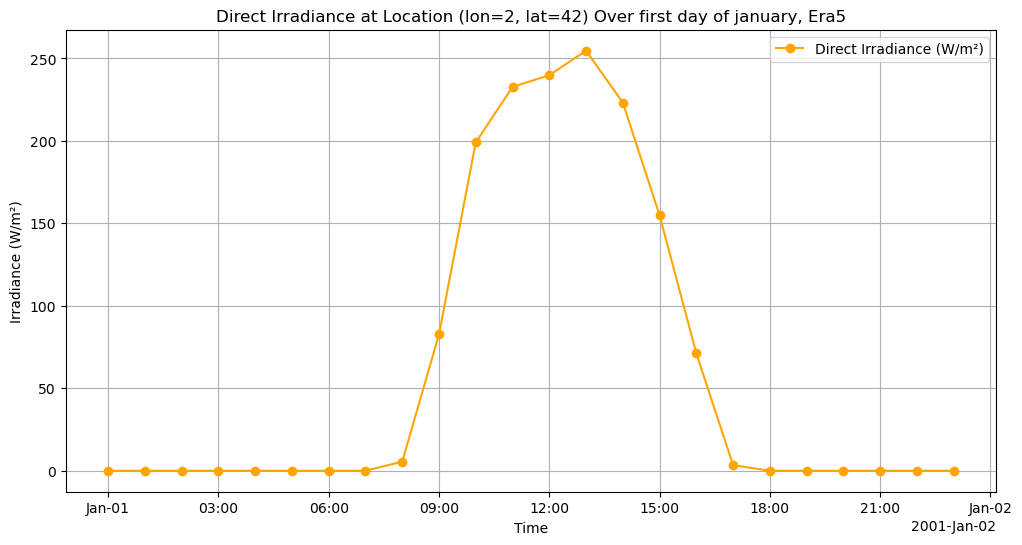

In [6]:
# Select the irradiance values for the specified location
direct_irradiance_era5 = df['influx_direct'].sel(x=2, y=42, method="nearest")

# Plot the irradiance values over time
plt.figure(figsize=(12, 6))
direct_irradiance_era5[:24].plot(label="Direct Irradiance (W/m²)", color="orange",marker="o")
plt.title("Direct Irradiance at Location (lon=2, lat=42) Over first day of january, Era5")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()

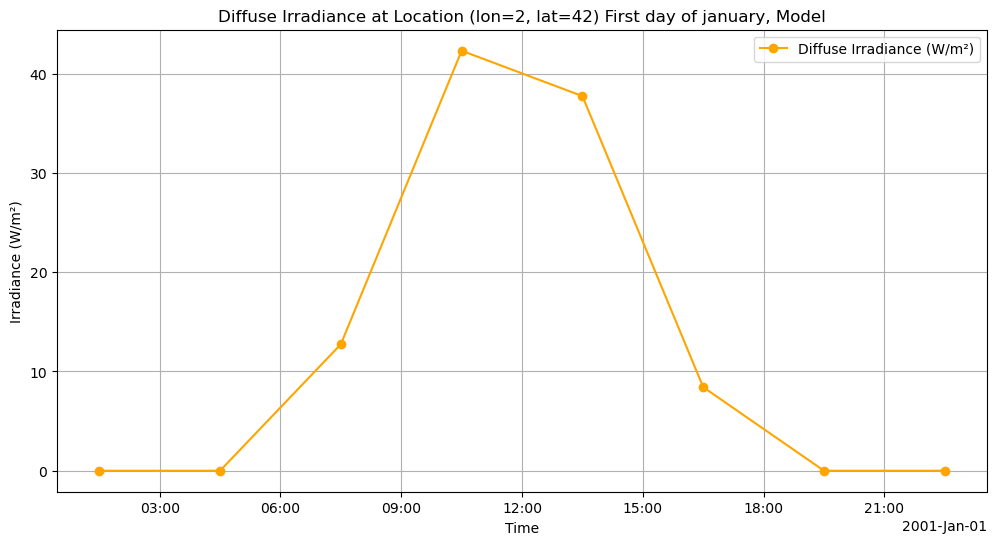

In [7]:
# Select the irradiance values for the specified location
diffuse_irradiance_model = ds['rsdsdiff'].sel(lon=2, lat=42, method="nearest")

# Plot the irradiance values over time
plt.figure(figsize=(12, 6))
diffuse_irradiance_model[:8].plot(label="Diffuse Irradiance (W/m²)", color="orange",marker="o")
plt.title("Diffuse Irradiance at Location (lon=2, lat=42) First day of january, Model")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()

In [21]:
diffuse_irradiance_model_sum = ds['rsdsdiff'].sel(lon=2, lat=42, method="nearest").sum(dim="time")
print(diffuse_irradiance_model_sum/1000)

<xarray.DataArray 'rsdsdiff' ()> Size: 4B
array(89.17945, dtype=float32)
Coordinates:
    lon      float32 4B 2.25
    lat      float32 4B 42.06


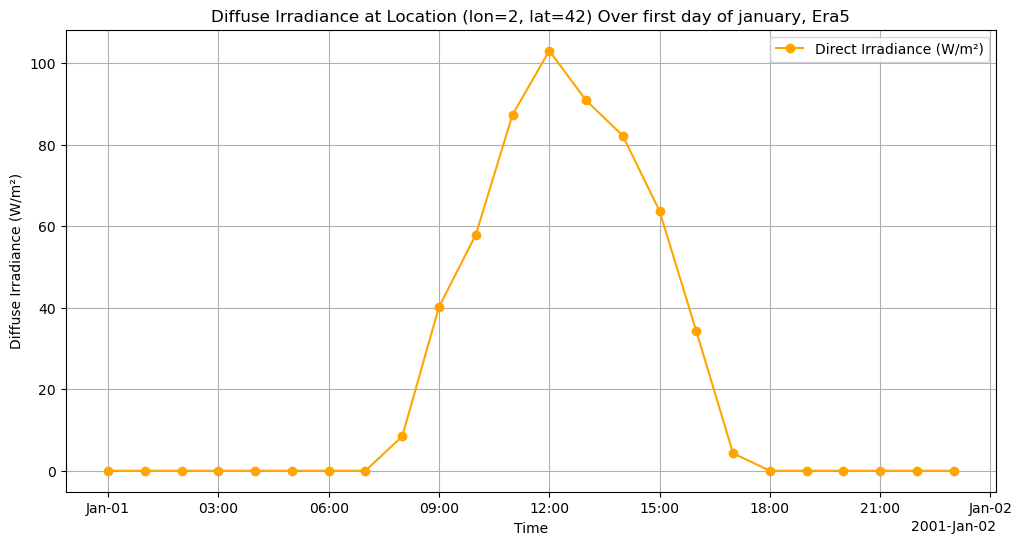

In [12]:
# Select the irradiance values for the specified location
diffuse_irradiance_era5 = df['influx_diffuse'].sel(x=2, y=42, method="nearest")

# Plot the irradiance values over time
plt.figure(figsize=(12, 6))
diffuse_irradiance_era5[:24].plot(label="Direct Irradiance (W/m²)", color="orange",marker="o")
plt.title("Diffuse Irradiance at Location (lon=2, lat=42) Over first day of january, Era5")
plt.xlabel("Time")
plt.ylabel("Diffuse Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()

In [27]:
direct_irradiance_era5_sum = df['influx_direct'].sel(x=2, y=42, method="nearest").values.sum()
print(direct_irradiance_era5_sum/1000)

1137.8652


In [29]:
rsds_model_original = "/groups/FutureWind/SFCRAD/MRI-ESM2-0/historical/r1i1p1f1/rsds_3hr_MRI-ESM2-0_historical_r1i1p1f1_gn_200001010130-200912312230.nc"
ds_rsds_model_original = xr.open_dataset(rsds_model_original)
rsdsdiff_model_original = "/groups/FutureWind/SFCRAD/MRI-ESM2-0/historical/r1i1p1f1/rsdsdiff_3hr_MRI-ESM2-0_historical_r1i1p1f1_gn_200001010130-200912312230.nc"
ds_rsdsdiff_model_original = xr.open_dataset(rsdsdiff_model_original)
ds_rsds_model_original

<xarray.Dataset> Size: 6GB
Dimensions:    (time: 29224, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) datetime64[ns] 234kB 2000-01-01T01:30:00 ... 2009-12-31...
  * lat        (lat) float64 1kB -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon        (lon) float64 3kB 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 468kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    rsds       (time, lat, lon) float32 6GB ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-18T10:26:01Z
    ...                     ...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    variable_id:            rsds
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/6a2744dc-3e12-4527-b4c8-3c0fe124152a

In [ ]:
diffuse_irradiance_era5_sum = df['influx_diffuse'].sel(x=2, y=42, method="nearest").values.sum()
print(diffuse_irradiance_era5_sum/1000)

493.0449


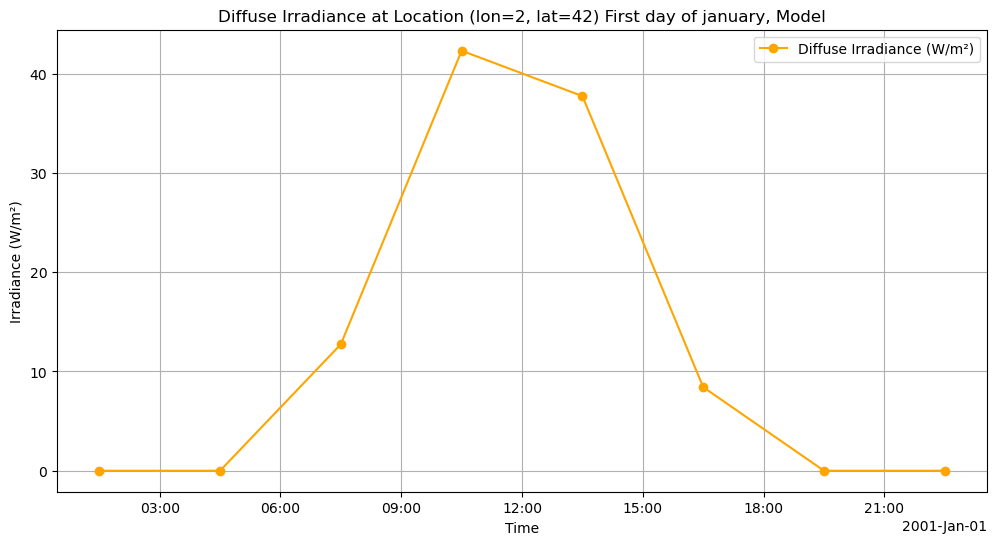

In [16]:
# Select the irradiance values for the specified location
diffuse_irradiance_model_o = ds_rsdsdiff_model_original['rsdsdiff'].sel(lon=2, lat=42, method="nearest")

# Plot the irradiance values over time
plt.figure(figsize=(12, 6))
diffuse_irradiance_model[:8].plot(label="Diffuse Irradiance (W/m²)", color="orange",marker="o")
plt.title("Diffuse Irradiance at Location (lon=2, lat=42) First day of january, Model")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()